# Introducción al Aprendizaje por Refuerzos II
## Nicolás Salusso - 10710

### 1.1 - Se modifica la implementación de SARSA para que el agente aprenda la política óptima empleando *Q-Learning* manteniendo la política (e-greedy).

#### Definición del modelo

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

# tamaño del entorno (Alto)
WORLD_HEIGHT = 7

# tamaño del entorno (Ancho)
WORLD_WIDTH = 10

# Fuerza del viento para cada columna
WIND = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

# Acciones posibles
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3

# probabilidad de exploración
EPSILON = 0.1

# Learning rate
ALPHA = 0.5

# reward
REWARD = -1.0

# valor de los pares estado acción
stateActionValues = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
startState = [3, 0]
goalState = [3, 7]
actions = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

# transiciones de estado
actionDestination = []
for i in range(0, WORLD_HEIGHT):
    actionDestination.append([])
    for j in range(0, WORLD_WIDTH):
        destination = dict()
        destination[ACTION_UP] = [max(i - 1 - WIND[j], 0), j]
        destination[ACTION_DOWN] = [max(min(i + 1 - WIND[j], WORLD_HEIGHT - 1), 0), j]
        destination[ACTION_LEFT] = [max(i - WIND[j], 0), max(j - 1, 0)]
        destination[ACTION_RIGHT] = [max(i - WIND[j], 0), min(j + 1, WORLD_WIDTH - 1)]
        actionDestination[-1].append(destination)

#### Función de iteración en un episodio

In [2]:
def oneEpisode():
    
    # acumulador de steps en el episodio
    time = 0

    # estado inicial
    currentState = startState
    
    # Función que selecciona la acción basada en epsilon-greedy
    def accion_por_politica():
        if np.random.binomial(1, EPSILON) == 1:
            accion = np.random.choice(actions)
        else:
            accion = np.argmax(stateActionValues[currentState[0], currentState[1], :])
        return accion
        

    # selección de acción basada en epsilon-greedy
    currentAction = accion_por_politica()

    # interactuar hasta arribar al estado objetivo
    while currentState != goalState:
        newState = actionDestination[currentState[0]][currentState[1]][currentAction]
        
        max_action = np.argmax(stateActionValues[newState[0], newState[1], :])
        
        stateActionValues[currentState[0], currentState[1], currentAction] += \
            ALPHA * (REWARD + stateActionValues[newState[0], newState[1], max_action] -
            stateActionValues[currentState[0], currentState[1], currentAction])
        
        currentState = newState
        currentAction = accion_por_politica()
        
        time += 1
    return time

#### Ejecución de los 500 episodios y obtencion de política óptima y gráfica.

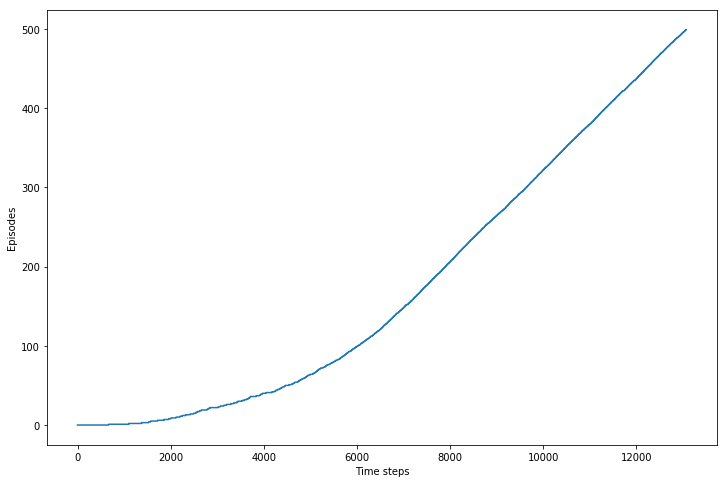

['L', 'D', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['L', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'L', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'G', 'R', 'D']
['R', 'D', 'R', 'R', 'R', 'R', 'U', 'D', 'L', 'L']
['U', 'D', 'D', 'R', 'R', 'U', 'U', 'D', 'R', 'D']
['L', 'R', 'L', 'R', 'U', 'U', 'U', 'U', 'D', 'L']
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


In [3]:
# Cantidad de episodios
episodeLimit = 500
ep = 0
episodes_q_learning = []
time = 0
time_acum = 0
grafica_q_learning = []
while ep < episodeLimit:
    time = oneEpisode()
    episodes_q_learning.extend([ep] * time)
    time_acum += time
    grafica_q_learning.append(time_acum/(ep + 1))
    ep += 1

plt.figure(figsize=(12, 8))
plt.plot(episodes_q_learning)
plt.xlabel('Time steps')
plt.ylabel('Episodes')
plt.show()

# Selección Greedy sobre la política...
optimalPolicyQLearning = []
for i in range(0, WORLD_HEIGHT):
    optimalPolicyQLearning.append([])
    for j in range(0, WORLD_WIDTH):
        if [i, j] == goalState:
            optimalPolicyQLearning[-1].append('G')
            continue
        bestAction = np.argmax(stateActionValues[i, j, :])
        if bestAction == ACTION_UP:
            optimalPolicyQLearning[-1].append('U')
        elif bestAction == ACTION_DOWN:
            optimalPolicyQLearning[-1].append('D')
        elif bestAction == ACTION_LEFT:
            optimalPolicyQLearning[-1].append('L')
        elif bestAction == ACTION_RIGHT:
            optimalPolicyQLearning[-1].append('R')
for row in optimalPolicyQLearning:
    print(row)
print([str(w) for w in WIND])

### 1.2 - Modificación de la implementación anterior para que el agente aprenda la política óptima empleando *SARSA($\lambda$)* manteniendo la política (e-greedy).

#### Definición del modelo

In [4]:
from __future__ import print_function
import numpy as np
# from python_utils.import_ import import_global
import matplotlib.pyplot as plt


# tamaño del entorno (Alto)
WORLD_HEIGHT = 7

# tamaño del entorno (Ancho)
WORLD_WIDTH = 10

# Fuerza del viento para cada columna
WIND = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

# Acciones posibles
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3

# probabilidad de exploración
EPSILON = 0.1

# Learning rate
ALPHA = 0.5

# reward
REWARD = -1.0

# valor de los pares estado acción
stateActionValues = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
startState = [3, 0]
goalState = [3, 7]
actions = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

# transiciones de estado
actionDestination = []
for i in range(0, WORLD_HEIGHT):
    actionDestination.append([])
    for j in range(0, WORLD_WIDTH):
        destination = dict()
        destination[ACTION_UP] = [max(i - 1 - WIND[j], 0), j]
        destination[ACTION_DOWN] = [max(min(i + 1 - WIND[j], WORLD_HEIGHT - 1), 0), j]
        destination[ACTION_LEFT] = [max(i - WIND[j], 0), max(j - 1, 0)]
        destination[ACTION_RIGHT] = [max(i - WIND[j], 0), min(j + 1, WORLD_WIDTH - 1)]
        actionDestination[-1].append(destination)

# LAMBDA
LAMBDA = 0.8

# Traza
e = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))

#### Función de iteración en un episodio

In [5]:
# interacción en un episodio
def oneEpisode():
    # acumulador de steps en el episodio
    time = 0

    # estado inicial
    currentState = startState

    # selección de acción basade en epsilon-greedy
    if np.random.binomial(1, EPSILON) == 1:
        currentAction = np.random.choice(actions)
    else:
        currentAction = np.argmax(stateActionValues[currentState[0], currentState[1], :])

    # interactuar hasta arribar al estado objetivo
    while currentState != goalState:
        newState = actionDestination[currentState[0]][currentState[1]][currentAction]
        if np.random.binomial(1, EPSILON) == 1:
            newAction = np.random.choice(actions)
        else:
            newAction = np.argmax(stateActionValues[newState[0], newState[1], :])
            
        # Sarsa(lambda) update
        
        # Se define delta
        delta = (REWARD + stateActionValues[newState[0], newState[1], newAction] -
            stateActionValues[currentState[0], currentState[1], currentAction])
        
        # Se actualiza la traza en el estado que se paso.
        e[currentState[0], currentState[1], currentAction] += 1
        
        for i in range(0, WORLD_HEIGHT):
            for j in range(0, WORLD_WIDTH):
                for action in actions:
                    stateActionValues[i, j, action] += ALPHA * delta * e[i, j, action]
                    e[i, j, action] = LAMBDA * e[i, j, action]

        currentState = newState
        currentAction = newAction
        time += 1
    return time

#### Ejecución de los 500 episodios y obtencion de política óptima y gráfica.

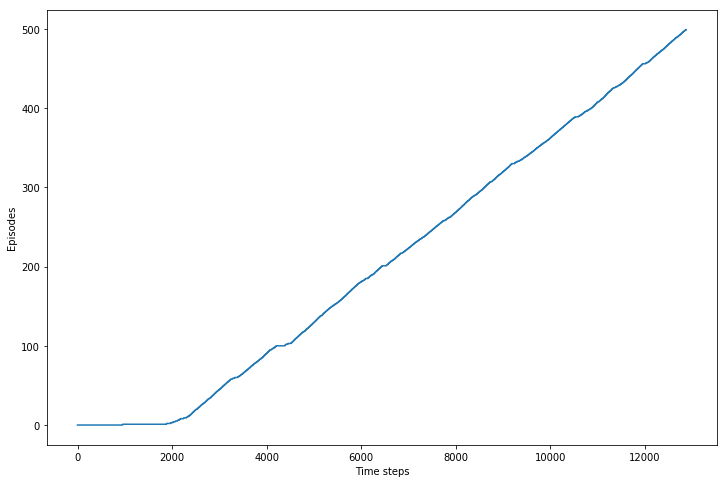

['R', 'L', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['L', 'R', 'D', 'R', 'U', 'R', 'U', 'U', 'R', 'D']
['R', 'R', 'R', 'R', 'D', 'U', 'L', 'R', 'R', 'D']
['U', 'R', 'R', 'U', 'U', 'R', 'L', 'G', 'R', 'D']
['R', 'R', 'U', 'D', 'R', 'U', 'U', 'L', 'L', 'L']
['R', 'R', 'R', 'U', 'R', 'U', 'U', 'D', 'D', 'R']
['R', 'R', 'R', 'R', 'U', 'U', 'U', 'U', 'L', 'L']
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


In [6]:
# Cantidad de episodios

episodeLimit = 500
ep = 0
episodes_graf_sarsa_lambda = []
time = 0
time_acum = 0
grafica_sarsa_lambda = []
while ep < episodeLimit:
    time = oneEpisode()
    episodes_graf_sarsa_lambda.extend([ep] * time)
    time_acum += time
    grafica_sarsa_lambda.append(time_acum/(ep + 1))
    ep += 1

plt.figure(figsize=(12, 8))
plt.plot(episodes_graf_sarsa_lambda)
plt.xlabel('Time steps')
plt.ylabel('Episodes')
plt.show()

# Selección Greedy sobre la política...
optimalPolicySarsaLambda = []
for i in range(0, WORLD_HEIGHT):
    optimalPolicySarsaLambda.append([])
    for j in range(0, WORLD_WIDTH):
        if [i, j] == goalState:
            optimalPolicySarsaLambda[-1].append('G')
            continue
        bestAction = np.argmax(stateActionValues[i, j, :])
        if bestAction == ACTION_UP:
            optimalPolicySarsaLambda[-1].append('U')
        elif bestAction == ACTION_DOWN:
            optimalPolicySarsaLambda[-1].append('D')
        elif bestAction == ACTION_LEFT:
            optimalPolicySarsaLambda[-1].append('L')
        elif bestAction == ACTION_RIGHT:
            optimalPolicySarsaLambda[-1].append('R')
for row in optimalPolicySarsaLambda:
    print(row)
print([str(w) for w in WIND])

### 1.3 - Comparación de convergecia en *SARSA*, *Q-Learning* y *SARSA(lambda)*

#### *SARSA*

In [7]:
from __future__ import print_function
import numpy as np
# from python_utils.import_ import import_global
import matplotlib.pyplot as plt


# tamaño del entorno (Alto)
WORLD_HEIGHT = 7

# tamaño del entorno (Ancho)
WORLD_WIDTH = 10

# Fuerza del viento para cada columna
WIND = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

# Acciones posibles
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3

# probabilidad de exploración
EPSILON = 0.1

# Learning rate
ALPHA = 0.5

# reward
REWARD = -1.0

# valor de los pares estado acción
stateActionValues = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
startState = [3, 0]
goalState = [3, 7]
actions = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

# transiciones de estado
actionDestination = []
for i in range(0, WORLD_HEIGHT):
    actionDestination.append([])
    for j in range(0, WORLD_WIDTH):
        destination = dict()
        destination[ACTION_UP] = [max(i - 1 - WIND[j], 0), j]
        destination[ACTION_DOWN] = [max(min(i + 1 - WIND[j], WORLD_HEIGHT - 1), 0), j]
        destination[ACTION_LEFT] = [max(i - WIND[j], 0), max(j - 1, 0)]
        destination[ACTION_RIGHT] = [max(i - WIND[j], 0), min(j + 1, WORLD_WIDTH - 1)]
        actionDestination[-1].append(destination)

# interacción en un episodio
def oneEpisode():
    # acumulador de steps en el episodio
    time = 0

    # estado inicial
    currentState = startState

    # selección de acción basade en epsilon-greedy
    if np.random.binomial(1, EPSILON) == 1:
        currentAction = np.random.choice(actions)
    else:
        currentAction = np.argmax(stateActionValues[currentState[0], currentState[1], :])

    # interactuar hasta arribar al estado objetivo
    while currentState != goalState:
        newState = actionDestination[currentState[0]][currentState[1]][currentAction]
        if np.random.binomial(1, EPSILON) == 1:
            newAction = np.random.choice(actions)
        else:
            newAction = np.argmax(stateActionValues[newState[0], newState[1], :])
        # Sarsa update
        stateActionValues[currentState[0], currentState[1], currentAction] += \
            ALPHA * (REWARD + stateActionValues[newState[0], newState[1], newAction] -
            stateActionValues[currentState[0], currentState[1], currentAction])
        currentState = newState
        currentAction = newAction
        time += 1
        
    return time

# Cantidad de episodios

episodeLimit = 500
ep = 0
episodes_graf_sarsa = []
time = 0
time_acum = 0
grafica_sarsa = []
while ep < episodeLimit:
    time = oneEpisode()
    episodes_graf_sarsa.extend([ep] * time)
    time_acum += time
    grafica_sarsa.append(time_acum/(ep + 1))
    ep += 1

optimalPolicySarsa = []
for i in range(0, WORLD_HEIGHT):
    optimalPolicySarsa.append([])
    for j in range(0, WORLD_WIDTH):
        if [i, j] == goalState:
            optimalPolicySarsa[-1].append('G')
            continue
        bestAction = np.argmax(stateActionValues[i, j, :])
        if bestAction == ACTION_UP:
            optimalPolicySarsa[-1].append('U')
        elif bestAction == ACTION_DOWN:
            optimalPolicySarsa[-1].append('D')
        elif bestAction == ACTION_LEFT:
            optimalPolicySarsa[-1].append('L')
        elif bestAction == ACTION_RIGHT:
            optimalPolicySarsa[-1].append('R')

#### Gráfica de la convergencia

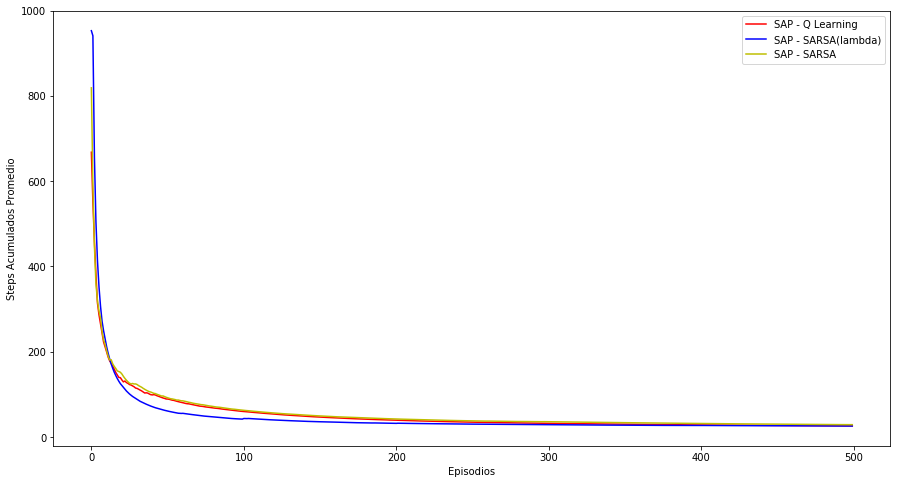

SAP = Steps Acumulados Promedio


In [8]:
plt.figure(figsize=(15, 8))
q_learning = plt.plot(grafica_q_learning, 'r-', label='SAP - Q Learning')
sarsa_lambda = plt.plot(grafica_sarsa_lambda, 'b-', label='SAP - SARSA(lambda)')
sarsa = plt.plot(grafica_sarsa, 'y-', label='SAP - SARSA')
plt.legend()
plt.xlabel('Episodios')
plt.ylabel('Steps Acumulados Promedio')
plt.show()

print('SAP = Steps Acumulados Promedio')

### 1.4 Políticas aprendidas para cada caso

In [9]:
print('Política óptima Q Learning')
for row in optimalPolicyQLearning:
    print(row)
print([str(w) for w in WIND])
print('')
print('Política óptima SARSA(lambda)')
for row in optimalPolicySarsaLambda:
    print(row)
print([str(w) for w in WIND])
print('')
print('Política óptima SARSA')
for row in optimalPolicySarsa:
    print(row)
print([str(w) for w in WIND])

Política óptima Q Learning
['L', 'D', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['L', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'L', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'G', 'R', 'D']
['R', 'D', 'R', 'R', 'R', 'R', 'U', 'D', 'L', 'L']
['U', 'D', 'D', 'R', 'R', 'U', 'U', 'D', 'R', 'D']
['L', 'R', 'L', 'R', 'U', 'U', 'U', 'U', 'D', 'L']
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']

Política óptima SARSA(lambda)
['R', 'L', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['L', 'R', 'D', 'R', 'U', 'R', 'U', 'U', 'R', 'D']
['R', 'R', 'R', 'R', 'D', 'U', 'L', 'R', 'R', 'D']
['U', 'R', 'R', 'U', 'U', 'R', 'L', 'G', 'R', 'D']
['R', 'R', 'U', 'D', 'R', 'U', 'U', 'L', 'L', 'L']
['R', 'R', 'R', 'U', 'R', 'U', 'U', 'D', 'D', 'R']
['R', 'R', 'R', 'R', 'U', 'U', 'U', 'U', 'L', 'L']
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']

Política óptima SARSA
['R', 'D', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'L', 'D']
[

### 1.5 Modificación de la implementación en *1.2* empleando King's Moves

#### Definición del modelo.

In [10]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt


# tamaño del entorno (Alto)
WORLD_HEIGHT = 7

# tamaño del entorno (Ancho)
WORLD_WIDTH = 10

# Fuerza del viento para cada columna
WIND = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

# Acciones posibles
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
ACTION_UP_RIGHT = 4
ACTION_UP_LEFT = 5
ACTION_DOWN_RIGHT = 6
ACTION_DOWN_LEFT = 7

# probabilidad de exploración
EPSILON = 0.1

# Learning rate
ALPHA = 0.5

# reward
REWARD = -1.0

# valor de los pares estado acción
stateActionValues = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 8))
startState = [3, 0]
goalState = [3, 7]
actions = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT,
           ACTION_UP_RIGHT, ACTION_UP_LEFT, ACTION_DOWN_RIGHT, ACTION_DOWN_LEFT]

# transiciones de estado
actionDestination = []
for i in range(0, WORLD_HEIGHT):
    actionDestination.append([])
    for j in range(0, WORLD_WIDTH):
        destination = dict()
        destination[ACTION_UP] = [max(i - 1 - WIND[j], 0), j]
        destination[ACTION_DOWN] = [max(min(i + 1 - WIND[j], WORLD_HEIGHT - 1), 0), j]
        destination[ACTION_LEFT] = [max(i - WIND[j], 0), max(j - 1, 0)]
        destination[ACTION_RIGHT] = [max(i - WIND[j], 0), min(j + 1, WORLD_WIDTH - 1)]
        destination[ACTION_UP_RIGHT] = [max(i - 1 - WIND[j], 0), min(j + 1, WORLD_WIDTH - 1)]
        destination[ACTION_UP_LEFT] = [max(i - 1 - WIND[j], 0), max(j - 1, 0)]
        destination[ACTION_DOWN_RIGHT] = [max(min(i + 1 - WIND[j], WORLD_HEIGHT - 1), 0), 
                                          min(j + 1, WORLD_WIDTH - 1)]
        destination[ACTION_DOWN_LEFT] = [max(min(i + 1 - WIND[j], WORLD_HEIGHT - 1), 0), 
                                         max(j - 1, 0)]
        actionDestination[-1].append(destination)

# LAMBDA
LAMBDA = 0.8

# Traza
e = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 8))

#### Función de iteración en un episodio.

In [11]:
def oneEpisode():
    # acumulador de steps en el episodio
    time = 0

    # estado inicial
    currentState = startState

    # selección de acción basade en epsilon-greedy
    if np.random.binomial(1, EPSILON) == 1:
        currentAction = np.random.choice(actions)
    else:
        currentAction = np.argmax(stateActionValues[currentState[0], currentState[1], :])

    # interactuar hasta arribar al estado objetivo
    while currentState != goalState:
        newState = actionDestination[currentState[0]][currentState[1]][currentAction]
        if np.random.binomial(1, EPSILON) == 1:
            newAction = np.random.choice(actions)
        else:
            newAction = np.argmax(stateActionValues[newState[0], newState[1], :])
            
        # Sarsa(lambda) update
        
        # Se define delta
        delta = (REWARD + stateActionValues[newState[0], newState[1], newAction] -
            stateActionValues[currentState[0], currentState[1], currentAction])
        
        # Se actualiza la traza en el estado que se paso.
        e[currentState[0], currentState[1], currentAction] += 1
        
        for i in range(0, WORLD_HEIGHT):
            for j in range(0, WORLD_WIDTH):
                for action in actions:
                    stateActionValues[i, j, action] += ALPHA * delta * e[i, j, action]
                    e[i, j, action] = LAMBDA * e[i, j, action]
        currentState = newState
        currentAction = newAction
        time += 1
    return time

#### Ejecución de los 500 episodios y obtencion de política óptima y gráfica.

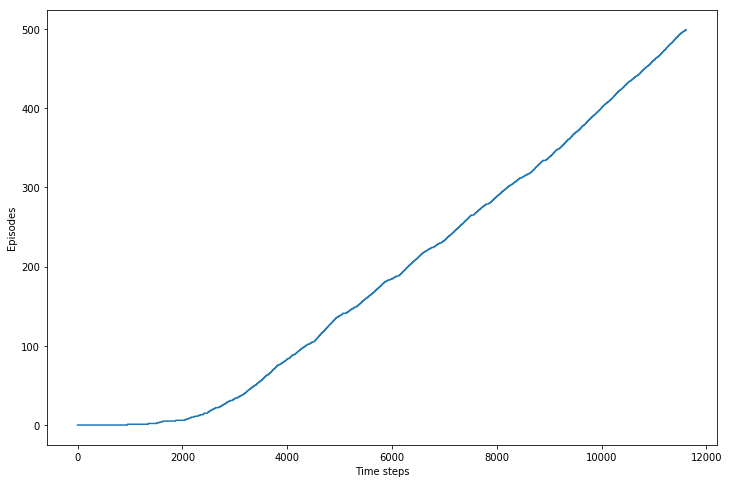

['UR', 'UR', 'DR', ' R ', 'UR', 'DR', ' R ', 'UR', 'DR', ' D ']
['UL', ' R ', ' R ', 'UR', ' R ', 'DR', ' U ', 'UR', 'UR', 'DR']
[' D ', 'UR', 'UR', ' R ', 'DR', ' R ', 'DR', ' U ', 'DR', ' D ']
['UR', ' R ', ' U ', 'DR', 'UR', ' L ', ' L ', ' G ', 'DL', ' L ']
['DR', ' D ', ' U ', 'UL', ' R ', 'UL', 'UL', 'UR', ' D ', 'DL']
[' U ', ' R ', 'UL', 'DR', ' L ', 'UL', ' R ', ' L ', 'UL', 'UR']
['UR', 'DR', ' R ', 'UL', 'UR', 'UR', ' U ', ' U ', 'UL', 'UL']
[' 0 ', ' 0 ', ' 0 ', ' 1 ', ' 1 ', ' 1 ', ' 2 ', ' 2 ', ' 1 ', ' 0 ']


In [12]:
# Cantidad de episodios
episodeLimit = 500
ep = 0
episodes = []
while ep < episodeLimit:
    time = oneEpisode()
    episodes.extend([ep] * time)
    ep += 1

plt.figure(figsize=(12, 8))
plt.plot(episodes)
plt.xlabel('Time steps')
plt.ylabel('Episodes')
plt.show()

# Selección Greedy sobre la política...
optimalPolicySarsaLambda = []
for i in range(0, WORLD_HEIGHT):
    optimalPolicySarsaLambda.append([])
    for j in range(0, WORLD_WIDTH):
        if [i, j] == goalState:
            optimalPolicySarsaLambda[-1].append(' G ')
            continue
        bestAction = np.argmax(stateActionValues[i, j, :])
        if bestAction == ACTION_UP:
            optimalPolicySarsaLambda[-1].append(' U ')
        elif bestAction == ACTION_DOWN:
            optimalPolicySarsaLambda[-1].append(' D ')
        elif bestAction == ACTION_LEFT:
            optimalPolicySarsaLambda[-1].append(' L ')
        elif bestAction == ACTION_RIGHT:
            optimalPolicySarsaLambda[-1].append(' R ')
        elif bestAction == ACTION_UP_RIGHT:
            optimalPolicySarsaLambda[-1].append('UR')
        elif bestAction == ACTION_UP_LEFT:
            optimalPolicySarsaLambda[-1].append('UL')
        elif bestAction == ACTION_DOWN_RIGHT:
            optimalPolicySarsaLambda[-1].append('DR')
        elif bestAction == ACTION_DOWN_LEFT:
            optimalPolicySarsaLambda[-1].append('DL')
for row in optimalPolicySarsaLambda:
    print(row)
print([' ' + str(w) + ' ' for w in WIND])

### 1.6 - Modificación de la implementación del ejercicio *1.2* asumiendo que la fuerza del viento varía de manera equiprobable entre el valor A establecido originalmente y A+1, A-1, el cual se determina para cada transición efectuada.

#### Definición del modelo

In [7]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import random

# tamaño del entorno (Alto)
WORLD_HEIGHT = 7

# tamaño del entorno (Ancho)
WORLD_WIDTH = 10

# Fuerza del viento para cada columna
WIND = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

# Acciones posibles
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3

# probabilidad de exploración
EPSILON = 0.1

# Learning rate
ALPHA = 0.5

# reward
REWARD = -1.0

# valor de los pares estado acción
stateActionValues = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
startState = [3, 0]
goalState = [3, 7]
actions = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

# transiciones de estado
def viento():
    actionDestination = []
    for i in range(0, WORLD_HEIGHT):
        actionDestination.append([])
        for j in range(0, WORLD_WIDTH):
            destination = dict()
            if WIND[j] != 0:
                wind = random.randint(WIND[j] - 1, WIND[j] + 1)
                destination[ACTION_UP] = [max(i - 1 - wind, 0), j]
                destination[ACTION_DOWN] = [max(min(i + 1 - wind, WORLD_HEIGHT - 1), 0), j]
                destination[ACTION_LEFT] = [max(i - wind, 0), max(j - 1, 0)]
                destination[ACTION_RIGHT] = [max(i - wind, 0), min(j + 1, WORLD_WIDTH - 1)]
                actionDestination[-1].append(destination)
            else:
                destination[ACTION_UP] = [max(i - 1 - WIND[j], 0), j]
                destination[ACTION_DOWN] = [max(min(i + 1 - WIND[j], WORLD_HEIGHT - 1), 0), j]
                destination[ACTION_LEFT] = [max(i - WIND[j], 0), max(j - 1, 0)]
                destination[ACTION_RIGHT] = [max(i - WIND[j], 0), min(j + 1, WORLD_WIDTH - 1)]
                actionDestination[-1].append(destination)
    return actionDestination

actionDestination = viento()
        

# LAMBDA
LAMBDA = 0.8

# Traza
e = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))

#### Función de iteración en un episodio

In [5]:
def oneEpisode():
    # acumulador de steps en el episodio
    time = 0

    # estado inicial
    currentState = startState

    # selección de acción basade en epsilon-greedy
    if np.random.binomial(1, EPSILON) == 1:
        currentAction = np.random.choice(actions)
    else:
        currentAction = np.argmax(stateActionValues[currentState[0], currentState[1], :])

    # interactuar hasta arribar al estado objetivo
    while currentState != goalState:
        actionDestination = viento()
        
        newState = actionDestination[currentState[0]][currentState[1]][currentAction]
        if np.random.binomial(1, EPSILON) == 1:
            newAction = np.random.choice(actions)
        else:
            newAction = np.argmax(stateActionValues[newState[0], newState[1], :])
            
        # Sarsa(lambda) update
        
        # Se define delta
        delta = (REWARD + stateActionValues[newState[0], newState[1], newAction] -
            stateActionValues[currentState[0], currentState[1], currentAction])
        
        # Se actualiza la traza en el estado que se paso.
        e[currentState[0], currentState[1], currentAction] += 1
        
        for i in range(0, WORLD_HEIGHT):
            for j in range(0, WORLD_WIDTH):
                for action in actions:
                    stateActionValues[i, j, action] += ALPHA * delta * e[i, j, action]
                    e[i, j, action] = LAMBDA * e[i, j, action]

        currentState = newState
        currentAction = newAction
        time += 1
    return time

#### Ejecución de los 500 episodios y obtencion de política óptima y gráfica.

In [6]:
# Cantidad de episodios
episodeLimit = 500
ep = 0
episodes = []
while ep < episodeLimit:
    time = oneEpisode()
    episodes.extend([ep] * time)
    ep += 1

plt.figure(figsize=(12, 8))
plt.plot(episodes)
plt.xlabel('Time steps')
plt.ylabel('Episodes')
plt.show()

# Selección Greedy sobre la política...
optimalPolicySarsaLambda = []
for i in range(0, WORLD_HEIGHT):
    optimalPolicySarsaLambda.append([])
    for j in range(0, WORLD_WIDTH):
        if [i, j] == goalState:
            optimalPolicySarsaLambda[-1].append('G')
            continue
        bestAction = np.argmax(stateActionValues[i, j, :])
        if bestAction == ACTION_UP:
            optimalPolicySarsaLambda[-1].append('U')
        elif bestAction == ACTION_DOWN:
            optimalPolicySarsaLambda[-1].append('D')
        elif bestAction == ACTION_LEFT:
            optimalPolicySarsaLambda[-1].append('L')
        elif bestAction == ACTION_RIGHT:
            optimalPolicySarsaLambda[-1].append('R')
for row in optimalPolicySarsaLambda:
    print(row)
print([str(w) for w in WIND])

entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entr

entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entr


entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
ent


entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
ent


entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
ent

entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entr


entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
ent

entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entr


entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
ent


entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
ent


entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
ent


entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
ent

entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entr


entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
ent

entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entr

entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entr

entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entr


entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
ent


entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
ent

entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entr

entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entr

entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entr

entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entr

entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entr

entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entr

entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entr


entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
ent


entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
ent

entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entr

entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entr


entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
ent

entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entr


entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
ent

entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entr

entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entr


entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
ent


entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
ent

entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entr

entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entr

KeyboardInterrupt: 

### 1.7 - Análisis de la convergencia de Sarsa($\lambda$) en *1.6* para 4 valores distintos de $\lambda$.

#### Definición del modelo

In [16]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import random

# tamaño del entorno (Alto)
WORLD_HEIGHT = 7

# tamaño del entorno (Ancho)
WORLD_WIDTH = 10

# Fuerza del viento para cada columna
WIND = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

# Acciones posibles
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3

# probabilidad de exploración
EPSILON = 0.1

# Learning rate
ALPHA = 0.5

# reward
REWARD = -1.0

# valor de los pares estado acción
stateActionValues = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
startState = [3, 0]
goalState = [3, 7]
actions = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

# transiciones de estado
actionDestination = []
for i in range(0, WORLD_HEIGHT):
    actionDestination.append([])
    for j in range(0, WORLD_WIDTH):
        destination = dict()
        if WIND[j] != 0:
            wind = random.randint(WIND[j] - 1, WIND[j] + 1)
            destination[ACTION_UP] = [max(i - 1 - wind, 0), j]
            destination[ACTION_DOWN] = [max(min(i + 1 - wind, WORLD_HEIGHT - 1), 0), j]
            destination[ACTION_LEFT] = [max(i - wind, 0), max(j - 1, 0)]
            destination[ACTION_RIGHT] = [max(i - wind, 0), min(j + 1, WORLD_WIDTH - 1)]
            actionDestination[-1].append(destination)
        else:
            destination[ACTION_UP] = [max(i - 1 - WIND[j], 0), j]
            destination[ACTION_DOWN] = [max(min(i + 1 - WIND[j], WORLD_HEIGHT - 1), 0), j]
            destination[ACTION_LEFT] = [max(i - WIND[j], 0), max(j - 1, 0)]
            destination[ACTION_RIGHT] = [max(i - WIND[j], 0), min(j + 1, WORLD_WIDTH - 1)]
            actionDestination[-1].append(destination)
            
        

# valores para lambda
lambdas = np.linspace(0.2, 0.9, 4)
print('Valores de lambda: \n{}'.format(lambdas))
# Traza
e = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))

Valores de lambda: 
[ 0.2         0.43333333  0.66666667  0.9       ]


#### Función de iteración en un episodio

In [17]:
# interacción en un episodio
def oneEpisode(l):
    
    # se setea el valor de LAMBDA
    LAMBDA = l
    
    # acumulador de steps en el episodio
    time = 0

    # estado inicial
    currentState = startState

    # selección de acción basade en epsilon-greedy
    if np.random.binomial(1, EPSILON) == 1:
        currentAction = np.random.choice(actions)
    else:
        currentAction = np.argmax(stateActionValues[currentState[0], currentState[1], :])

    # interactuar hasta arribar al estado objetivo
    while currentState != goalState:
        newState = actionDestination[currentState[0]][currentState[1]][currentAction]
        if np.random.binomial(1, EPSILON) == 1:
            newAction = np.random.choice(actions)
        else:
            newAction = np.argmax(stateActionValues[newState[0], newState[1], :])
            
        # Sarsa(lambda) update
        
        # Se define delta
        delta = (REWARD + stateActionValues[newState[0], newState[1], newAction] -
            stateActionValues[currentState[0], currentState[1], currentAction])
        
        # Se actualiza la traza en el estado que se paso.
        e[currentState[0], currentState[1], currentAction] += 1
        
        for i in range(0, WORLD_HEIGHT):
            for j in range(0, WORLD_WIDTH):
                for action in actions:
                    stateActionValues[i, j, action] += ALPHA * delta * e[i, j, action]
                    e[i, j, action] = LAMBDA * e[i, j, action]

        currentState = newState
        currentAction = newAction
        time += 1
    return time

#### Ejecución de los 500 episodios, obtención de política óptima y gráfica para cada uno de los valores de $\lambda$ definidos anteriormente.

Con LAMBDA=0.2


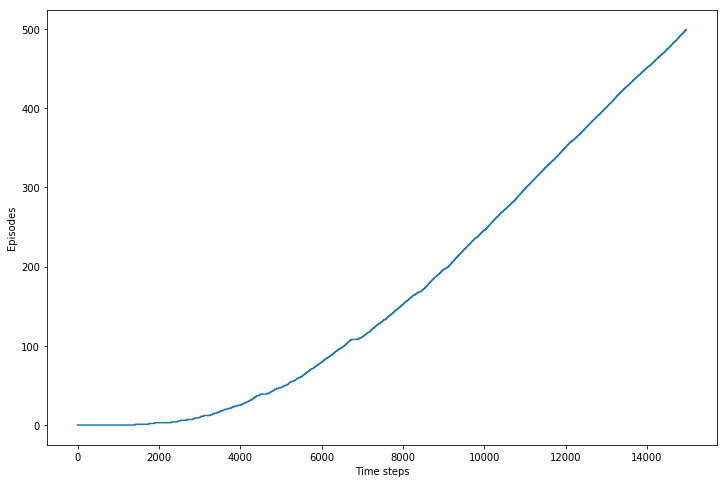

['L', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'R', 'R', 'R', 'U', 'R', 'R', 'D', 'R', 'D']
['U', 'U', 'R', 'R', 'R', 'R', 'R', 'D', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'D', 'G', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'U', 'U', 'D', 'R', 'D']
['R', 'L', 'R', 'R', 'U', 'U', 'U', 'D', 'L', 'L']
['R', 'R', 'R', 'R', 'U', 'U', 'U', 'U', 'R', 'U']
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


Con LAMBDA=0.43333333333333335


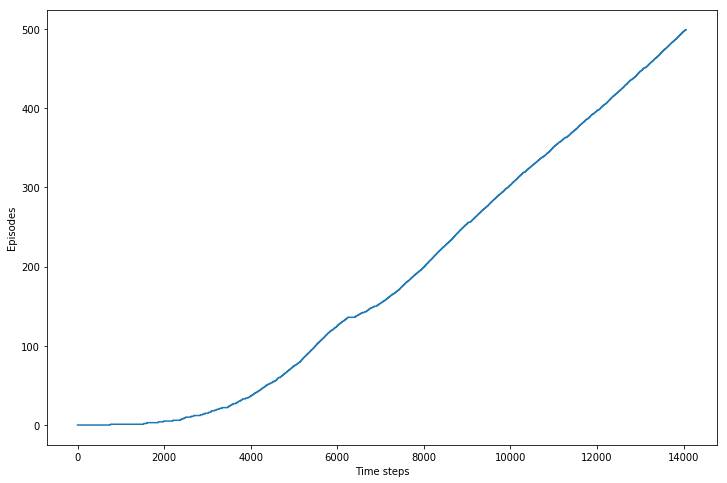

['L', 'D', 'R', 'R', 'R', 'R', 'R', 'R', 'D', 'D']
['U', 'R', 'R', 'R', 'R', 'D', 'R', 'R', 'R', 'D']
['R', 'U', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'G', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'U', 'U', 'R', 'R', 'D']
['D', 'R', 'D', 'D', 'U', 'U', 'U', 'L', 'L', 'L']


['L', 'R', 'R', 'R', 'U', 'U', 'U', 'U', 'L', 'L']
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']
Con LAMBDA=0.6666666666666666


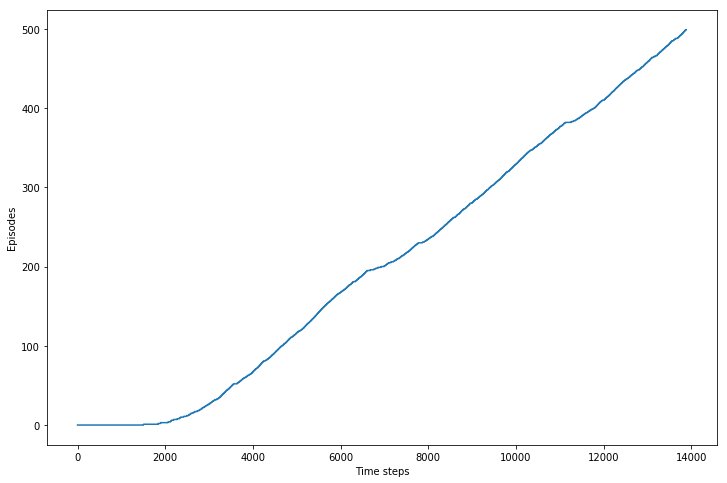

['L', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'U', 'R', 'R', 'D', 'U', 'U', 'L', 'R', 'D']
['R', 'U', 'D', 'U', 'R', 'R', 'L', 'R', 'D', 'D']
['R', 'R', 'R', 'R', 'R', 'L', 'D', 'G', 'U', 'D']
['R', 'U', 'U', 'R', 'D', 'U', 'U', 'D', 'R', 'D']
['D', 'L', 'R', 'R', 'U', 'U', 'U', 'D', 'L', 'L']
['U', 'U', 'R', 'L', 'U', 'U', 'U', 'U', 'R', 'U']
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


Con LAMBDA=0.9


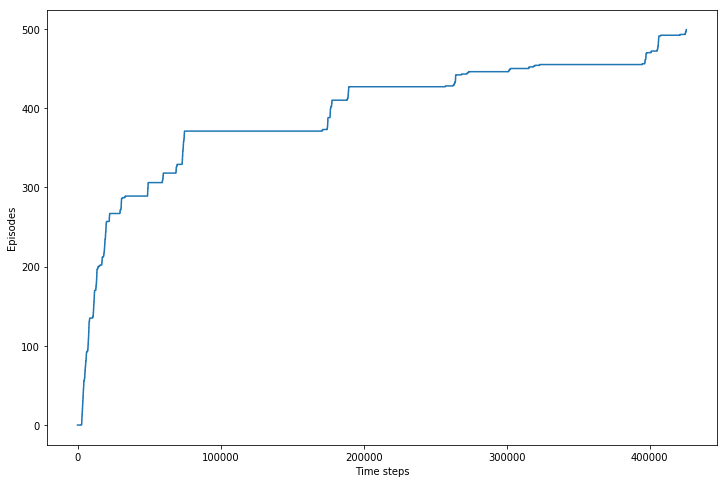

['R', 'D', 'L', 'D', 'R', 'R', 'R', 'R', 'D', 'U']
['U', 'D', 'L', 'L', 'L', 'D', 'U', 'R', 'R', 'D']
['U', 'D', 'L', 'D', 'L', 'R', 'L', 'U', 'D', 'D']
['R', 'D', 'D', 'L', 'R', 'U', 'R', 'G', 'R', 'D']
['U', 'R', 'D', 'U', 'L', 'U', 'U', 'L', 'R', 'D']
['R', 'R', 'R', 'R', 'U', 'U', 'U', 'R', 'L', 'L']
['L', 'U', 'L', 'D', 'U', 'U', 'U', 'U', 'U', 'D']
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


In [18]:
grafica_sarsa_lambdas = []
for l in lambdas:
    # se setean las variables iniciales
    e = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
    stateActionValues = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
    
    grafica_sarsa_lambdas.append([])
    # Cantidad de episodios por lamda
    episodeLimit = 500
    ep = 0
    episodes_graf_sarsa_lambda = []
    time = 0
    time_acum = 0
    while ep < episodeLimit:
        time = oneEpisode(l)
        episodes_graf_sarsa_lambda.extend([ep] * time)
        time_acum += time
        grafica_sarsa_lambdas[-1].append(time_acum/(ep + 1))
        ep += 1
    
    print('Con LAMBDA={}'.format(l))
    plt.figure(figsize=(12, 8))
    plt.plot(episodes_graf_sarsa_lambda)
    plt.xlabel('Time steps')
    plt.ylabel('Episodes')
    plt.show()
    
    # Selección Greedy sobre la política...
    optimalPolicySarsaLambda = []
    for i in range(0, WORLD_HEIGHT):
        optimalPolicySarsaLambda.append([])
        for j in range(0, WORLD_WIDTH):
            if [i, j] == goalState:
                optimalPolicySarsaLambda[-1].append('G')
                continue
            bestAction = np.argmax(stateActionValues[i, j, :])
            if bestAction == ACTION_UP:
                optimalPolicySarsaLambda[-1].append('U')
            elif bestAction == ACTION_DOWN:
                optimalPolicySarsaLambda[-1].append('D')
            elif bestAction == ACTION_LEFT:
                optimalPolicySarsaLambda[-1].append('L')
            elif bestAction == ACTION_RIGHT:
                optimalPolicySarsaLambda[-1].append('R')
    for row in optimalPolicySarsaLambda:
        print(row)
    print([str(w) for w in WIND])

#### Gráfica de comparación para el análisis

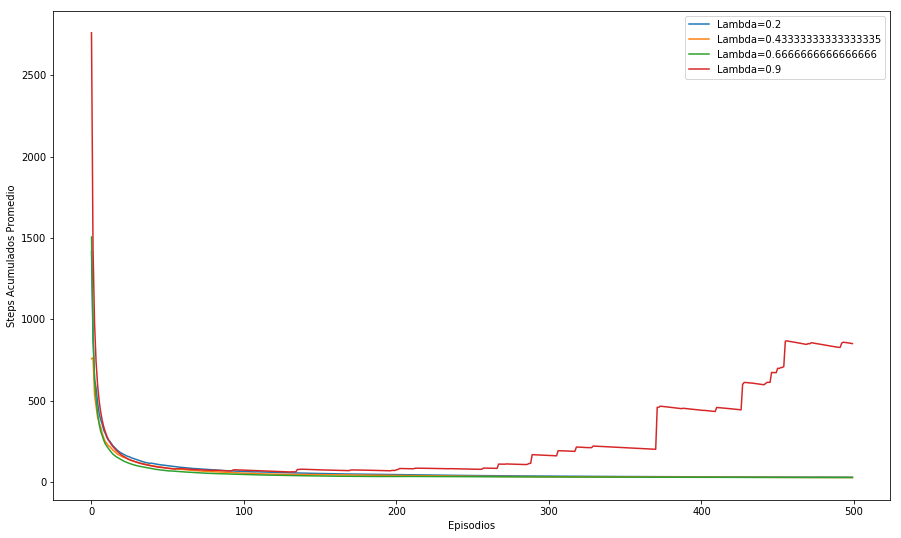

In [19]:
plt.figure(figsize=(15, 9))
indice = 0
for row in grafica_sarsa_lambdas:
    plt.plot(row, label='Lambda={}'.format(lambdas[indice]))
    indice += 1
plt.legend()
plt.xlabel('Episodios')
plt.ylabel('Steps Acumulados Promedio')
plt.show()

En esta gráfica se puede observar el problema de no resetear la traza y tener un valor alto de lambda


FIN